<a name="top"></a>|

<div style="width:1000 px">
<div style="float:right; width:300 px"><img src="https://github.com/brianmapes/ATM407/blob/master/images/EnergyMassPlot_spaghettiplot.png?raw=true" alt="(EnergyMassPlot example image here)" style="height: 200px;"></div>

<h1>Parcel theory: irreversible and reversible processes, CAPE/CINE, and entrainment methods.</h1>
<h3>Wei-Ming Tsai, Apr. 2019@RSMAS</h3>

This project stems from [Prof. Brian Mapes's notebook](https://github.com/ATMOcanes/ATM663_convection_meso/blob/master/Resources/Notebooks/Real_Parcel_Buoyancy.ipynb)

0. <a href="#intro">Introduction of this project</a>
1. <a href="#functions">Define thermo functions
1. <a href="#b_from_s">Undilute parcel buoyancy: entropy conserving</a>
1. <a href="#pseudo">Pseudoadiabatic vs. reversible</a>
1. <a href="#b_from_h">Undilute parcel buoyancy: MSE conserving</a>
1. <a href="#include_ice">Considering the latent heat of freezing</a>
1. <a href="#entraining">Entraining plume of MSE</a>
1. <a href="#CAPE">CAPE of entraining plume of MSE</a>
1. <a href="#sens">Sensitivity of CAPE of entraining plume of MSE</a>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<a name="intro"></a>
# <font color='green'>Introduction 

The concept of a parcel is fundamental to the understanding of convective processes. This notebook is applying a 1-D parcel model with different assumptions and entrainment treatments to understand the following topics:<br>
<br>
<font color='blue'>(1) reversible and irreversible processes based on different assumptions <br> 
<font color='blue'>(2) the effect of considering latent heat of freezing on parcel buoyancy<br>
<font color='blue'>(3) entraiment effects on parcel buoyancy using a constant entrainment rate and entrainment rates varying with height<br>
<br>
<font color='k'>The mean sounding profile of Miami 2018 summer (JJA) is applied here and variables are interpolated into pressure levels with $\Delta$p=10 hPa from 1020hPa to 20hPa for entrainment calculations.

In [1]:
%pylab inline
# makes plots appear inline in the notebook, cheaty/simple way

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import MSEplots.plots as mpt

import metpy.calc as mpcalc
from metpy import units
from metpy.constants import Cp_d,Lv,Rd,g 
from metpy.calc.thermo import *
from siphon.simplewebservice.wyoming import WyomingUpperAir

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Tropical sounding profile 

In [4]:
# 2018 JJA mean profile
T,Td,Z,p = np.loadtxt('MFL_vars_2018.txt') # sounding profile input 
r = mixing_ratio( saturation_vapor_pressure(Td*units.units('degC')), p*units.units('hPa') ) 
q = specific_humidity_from_mixing_ratio(r)
rs = mixing_ratio( saturation_vapor_pressure(T*units.units('degC')), p*units.units('hPa') ) 
qs = specific_humidity_from_mixing_ratio(rs)

Text(0.5, 1.0, 'Wyoming Upper Air, Miami (12.4S, 130.89E), 2018 JJA')

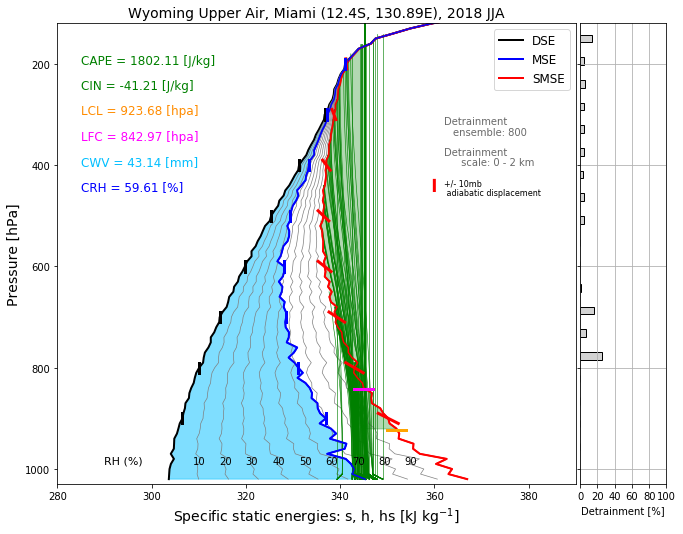

In [6]:
ax = mpt.msed_plots(p,T,q,Z,ent_rate=np.arange(0,2,0.05),entrain=True) # altitude included
ax.set_title('Wyoming Upper Air, Miami (12.4S, 130.89E), 2018 JJA', fontsize=14)

In [8]:
#from siphon.simplewebservice.wyoming import WyomingUpperAir

#date = datetime(2018, 6, 22, 0)
#station = 'MFL'

#df = WyomingUpperAir.request_data(date, station)
#p = df['pressure'].values #hPa
#T = df['temperature'].values  #C
#Td = df['dewpoint'].values #C
#Z = df['height'].values   #m

#r = mixing_ratio( saturation_vapor_pressure(Td*units.units('degC')), p*units.units('hPa') ) 
#q = specific_humidity_from_mixing_ratio(r)
#rs = mixing_ratio( saturation_vapor_pressure(T*units.units('degC')), p*units.units('hPa') ) 
#qs = specific_humidity_from_mixing_ratio(rs)

In [9]:
#ax = mpt.msed_plots(p,T,q,Z,ent_rate=np.arange(0,2,0.05),entrain=True) # altitude included
#ax.set_title('Wyoming Upper Air, Majuro (7.07N, 171.29E), 2018/08/24', fontsize=14)

-------------
<a name="functions"></a>
### Functions needed for moist thermo calculations

In [10]:
# Package of thermo functions 

import numpy as np

def esat(T):
# Saturation vapor pressure IN HPA as a function of temperature IN CELSIUS
    if( np.max(np.abs(T)) > 100 ) :
        print, 'esat: Please provide T in CELSIUS ', np.max(np.abs(T))
        #return 0

# This one is from Emanuel page 116 (4.4.13), over liquid at all temperatures
    Tref = 273.15
    ESAT = np.exp( 53.67957 - 6743.769/(T+Tref) - 4.8451*np.log(T+Tref) )

    # Water only  
    return ESAT 

def esati(T):
# Saturation vapor pressure IN HPA as a function of temperature IN CELSIUS
    if( np.max(np.abs(T)) > 100 ) :
        print, 'esat: Please provide T in CELSIUS ', np.max(np.abs(T))
        return 0

    # This one is from Emanuel page 116 (4.4.13), over liquid at all temperatures
    Tref = 273.15
    ESAT = np.exp( 53.67957 - 6743.769/(T+Tref) - 4.8451*np.log(T+Tref) )
    # This one is over ice, but valid at subzero temperatures only
    ESATI = np.exp( 23.33086 - 6111.72784/(T+Tref) + 0.15215*np.log(T+Tref) )

    # Stitch them together into the optput array based on sign of T in C    
    return np.where(T>0, ESAT,ESATI)


def mixrat(Td,p):
# Td in C# p in mb
    if( np.max(np.abs(Td)) > 100 or np.max(np.abs(p)) > 1050) :
        print, 'mixrat: provide Td in C, p in mb',np.max(np.abs(Td)),np.max(np.abs(p))
        #return 0

    # simple formula with 0.622 rato of molecular weight or R vapor vs. air    
    es = esat(Td)
    return 0.622 * es / (p-es)


def entropy(T,p,qtot): 

# T in C, p in mb, qtot in kg/kg
    if( np.max(T) > 100. or np.max(np.abs(p)) > 1050. or np.max(np.abs(qtot)) > 0.1 ):
        print( 'entropy: provide T in centigrade, p in mb, qtot in kg/kg') 
        print( T,p,qtot )
        return 0

    # from Raymond & Blyth 1992
    Tref = 273.15 
    pref = 1000.0
    Cpd = 1005.		# dry air heat capacity at const p
    Cpv = 1850.		# water vapor heat capacity at const p
    Rv = 461.51		# Gas constant for vapor
    Rd = 287.05		# Gas constant for dry air
    Lref = 2.501e6 		# vaporization heat at Tref
    Cl  =  4218.		# liquid water heat capacity
    eref = 6.106		# sat p at Tref (mb)

    L = Lref - (Cl - Cpv)*T		# T ARRAY IN CENTIGRADE

    qsat = mixrat(T,p)
    qv = np.where(qtot < qsat,qtot, qsat)
    e = esat(T) *qv/qsat

    s = (Cpd + qtot*Cl)*np.log( (T+Tref)/Tref ) - Rd*np.log( (p-e)/pref ) + \
        L*qv/(T+Tref) - qv*Rv*np.log(qv/qsat)

    return s

def invert_entropy(sm,qt,p):
# Inverts entropy sm & total water qt at pressures p (mb) 
# Returns T & qv vapor mixing ratio
# Met units: mb, C, kg/kg 

    LOOPMAX =  200 #  /* max number of iteration loops */

    #/* invert the entropy equation -- use Newton's method. Measure ds for dT=1K

    ts = 200.0 + p/10. - 273.16	 # crude first guess (C)    
    for i in range(0, LOOPMAX+1):
        fs0 = entropy(ts,p,qt) - sm
        fs1 = entropy(ts - 1.,p,qt) - sm
        dts = fs0/(fs1 - fs0) # dT/ds * (entropy error of guess ts)
        ts  = ts+dts          # correct that guess, linearized way
        
        #print('loop iteration i',i,'largest error is:', np.max(np.abs(dts)))

        if (np.max(np.abs(dts)) < .01): break # this will end the loop 
        if (i == LOOPMAX - 1):
            print( "s invert not converging" )
            return 0
                
# gather up result and return it
    T = ts   # latest guess from iteration
    qvsat = mixrat(T,p)		#/* saturation mixing ratio at computed temp */
    qv = np.where(qt < qvsat,qt, qvsat)      #/* check for saturation */

    return T,qv 


def MSE(T,Z,qv): # units C, m, kg/kg
    Cp = 1005.		# dry air heat capacity at const p
    L = 2.501e6 		# vaporization heat at Tref
    g = 9.8 
    Tref = 273.16
    
    return Cp*(T+Tref) + g*Z + L*qv


def invert_MSE(h,qt,Z,p):
# Inverts h value & total water qt at a set of heights Z (in m) and pressures p (in mb)
# Returns T & qv vapor mixing ratio of parcel
# Met units: m, C, kg/kg, mb

#/* invert the transitive MSE equation -- use Newton's method
    LOOPMAX =  400 #  /* max number of iteration loops */

    ts = h*0 +20 -6*Z/1000. # crude first guess at T (6 K/km lapse rate)

# Now iterate
    for i in range(0, LOOPMAX+1):
        
    # The MSE profile based on guess ts and min(qt,qvsat)
        qsat0 = mixrat(ts, p)
        qv0 = np.where(qt<qsat0,qt, qsat0)
        MSE0 = MSE(ts,   Z, qv0      ) 

    # now MSE profile for a +1K perturbation
        qsat1 = mixrat(ts+1, p)
        qv1 = np.where(qt<qsat1,qt, qsat1)
        MSE1 = MSE(ts+1,Z, qv1) 
        
    # So we can estimate the derivative dMSE/dT
        dMSEdT = MSE1-MSE0      # J/kg per K 
        
    # Use that derivative to estimate the correction to the guess ts
        dts = (h-MSE0)/dMSEdT # convert MSE error of first guess ts to K units
        ts  = ts+dts          # correct initial T guess using that slope
            
    # test if correction is small, and quit if so. Otherwise, repeat. 
        if (np.max(np.abs(dts)) < .01): break # end loop 
        if (i == LOOPMAX - 1) :
            print( "MSE invert not converging" )
            #return 0
                
    # After the corrections have converged, gather up result and return it
    qvsat = mixrat(ts,p)		#/* saturation mixing ratio at computed temp */
    qv = np.where(qt < qvsat,qt, qvsat)      #/* check for saturation */

    return ts,qv 

---------------
<a name="plots"></a>
### Diagrams for static energy and entropy 

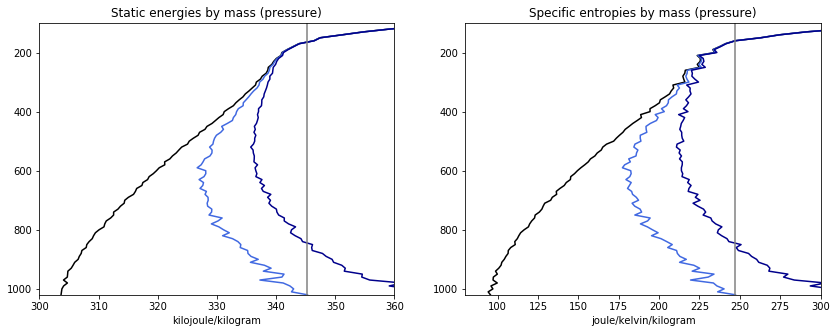

In [11]:
fig = plt.figure(figsize=(14,5))

s = MSE(T,Z,q*1e-9) /1000*units.units('kJ/kg')
h = MSE(T,Z,q)      /1000*units.units('kJ/kg')
hs = MSE(T,Z,qs)    /1000*units.units('kJ/kg')

ax1 = plt.subplot(1,2,1)
ax1.plot(s, p, 'k')
ax1.plot(h, p, 'royalblue')
ax1.plot(hs, p, 'darkblue')
ax1.set_xlim([300,360]); ax1.set_ylim([1020,100]); ax1.set_title('Static energies by mass (pressure)')
ax1.plot(h*0+h[0],p,'grey')

sd = entropy(T,p,q*1e-6) *units.units('J/kg/K')
sm = entropy(T,p,q)      *units.units('J/kg/K')
sms = entropy(T,p,qs)    *units.units('J/kg/K')
cwv = mpcalc.precipitable_water(Td*units.units('degC'),p*units.units('mbar'))

ax2 = plt.subplot(1,2,2)
ax2.plot(sd, p, 'k')
ax2.plot(sm, p, 'royalblue')
ax2.plot(sms, p, 'darkblue')
#for n in range(3):
#    ax2.plot(sm_mod[n,:], p,'--',color='royalblue')

ax2.set_ylim([1020,100]); ax2.set_xlim([80,300]); ax2.set_title('Specific entropies by mass (pressure)')
ax2.plot(sm*0+sm[0],p,'grey')

## <font color='green'>1. Assumptions in the parcel thoery 

### Reversible process
- During the reversible process, **the MSE /entropy and total water are conserved**
- Condensate is carried by the rising parcel all the way to upper levels, **0% precipitation efficiency!**
- There is no external exchange of heat and mass between the parcel and the environment!

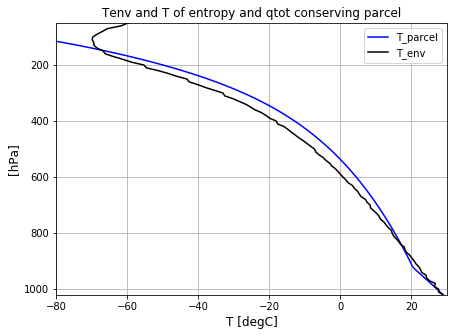

In [13]:
fig = plt.figure(figsize=(7,5))

sm = entropy(T,p,q)      #*units.units('J/kg/K')
qtot = q[0] # total water content
Tp,qvp = invert_entropy(sm[0],qtot, np.where(p>50,p,50))

plot(Tp,p,'b'); plot(T,p,'k')
ylim([1020,50]); xlim([-80,30]); title('Tenv and T of entropy and qtot conserving parcel')
plt.legend(['T_parcel','T_env'])
ylabel('[hPa]',fontsize=12);xlabel('T [degC]',fontsize=12)
plt.grid()

In [15]:
# http://glossary.ametsoc.org/wiki/Virtual_temperature
def Tv(T,qv): 
    Tref = 273.16
    return (1 + 0.61*qv)*(T+Tref) - Tref # virtual temperature

def Trho(T,qv,qc): 
    Tref = 273.16
    return (1 + 0.61*qv -qc)*(T+Tref) - Tref # density temperature, considering condensed water loading

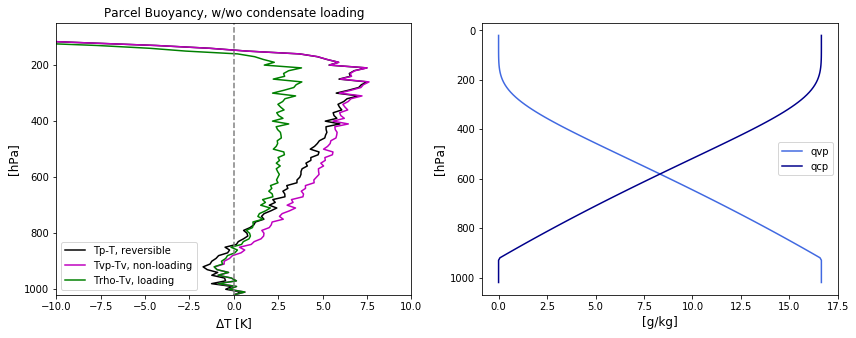

In [53]:
qcp = qtot - qvp

fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(Tp-T,p,'k')
ax1.plot( Trho(Tp,qvp,0)-Tv(T,q) ,p,'m')
ax1.plot( Trho(Tp,qvp,qcp)-Tv(T,q),p ,'g'); plot(p*0,p,'--',color='grey') # less buoyant due to condensed water loading
ax1.set_ylim([1020,50]); ax1.set_xlim([-10,10]); ax1.set_title('Parcel Buoyancy, w/wo condensate loading')
ax1.legend(['Tp-T, reversible','Tvp-Tv, non-loading','Trho-Tv, loading'])
ax1.set_xlabel('$\Delta$T [K]',fontsize=12)
ax1.set_ylabel('[hPa]',fontsize=12)

ax2 = plt.subplot(1,2,2)
ax2.plot(qvp*1000,p,'royalblue')
ax2.plot(qcp*1000,p,'darkblue')
ax2.set_xlabel('[g/kg]',fontsize=12)
ax2.set_ylabel('[hPa]',fontsize=12)
ax2.invert_yaxis()
ax2.legend(['qvp','qcp'])

dTrho_entropy = Trho(Tp,qvp,qcp)-Tv(T,q)

Green and purple lines overlap below 963hpa (LCL) where water vapor in the rising parcel is not saturated yet.
Total water content is conserved during the reversible process.

---------------
<a name="pseudo"></a>
### Irreversible process: pseudo-adiabatic process
- The MSE /entropy is nearly conserved, but **the total water is Not conserved**
- Liquid water is removed immediately from the rising parcel once it forms, **100% precipitation efficiency!**
- The mass of eliminated condensate can be negligible comparing to the mass of parcel

Text(0.5, 1.0, 'Reversible vs. pseudo-adiabatic Trho excesses')

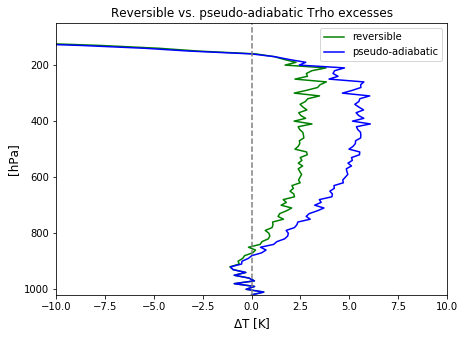

In [18]:
Tp_precip,qvp_precip = invert_entropy(sm[0],qvp, np.where(p>100,p,100)) # conserving energy

fig = plt.figure(figsize=(7,5))
plot( Trho(Tp,       qvp,       qcp  )-Tv(T,q) ,p, 'g') # reversible 
plot( Trho(Tp_precip,qvp_precip, 0)-Tv(T,q) ,p, 'b'); plot(p*0,p,'--',color='grey') # persudo-adiabatic
ylabel('[hPa]',fontsize=12); xlabel('$\Delta$T [K]',fontsize=12)
plt.legend(['reversible','pseudo-adiabatic'])

ylim([1020,50]); xlim([-10,10]); title('Reversible vs. pseudo-adiabatic Trho excesses')

In the pseudo-adiabatic process, the liquid water is removed out immediately once it forms. This assumption eliminates the effect of condensate loading and heat capacity of condensate, so the density temperature is warmer than that in the reversible process. However, this assumption also implies a 100% precipitation efficiency, which apparently conflicts with observations.

---------------
<a name="b_from_h"></a>
### Compute parcel b (as T excesses), conserving MSE and q (total water)

In [20]:
s = MSE(T,Z,q*1e-9) #/1000*units.units('kJ/kg')
h = MSE(T,Z,q)      #/1000*units.units('kJ/kg')
hs = MSE(T,Z,qs)    #/1000*units.units('kJ/kg')

TpMSE,qvpMSE = invert_MSE(h[0],q[0], np.where(Z<18000.,Z,18000.), np.where(p>100.,p,100.))
qcpMSE = q[0]-qvpMSE

MSE invert not converging


MSE invert not converging


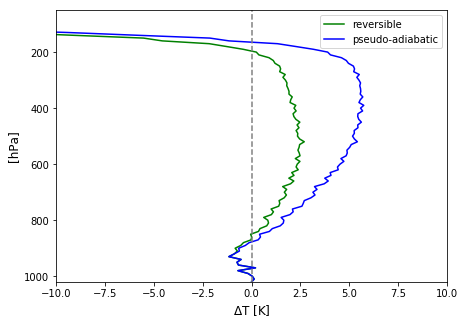

In [21]:
fig = plt.figure(figsize=(7,5))
Tp_precip,qvp_precip = invert_MSE(h[0],qvpMSE, np.where(Z<20000.,Z,20000.),np.where(p>100,p,100)) # conserving energy

plot( Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q) ,p, 'g') # MSE-conserved T
plot( Trho(Tp_precip,qvp_precip,0)-Tv(T,q) ,p, 'b') # persudo-adiabatic
plot(p*0,p,'--',color='grey') 

ylim([1020,50]); xlim([-10,10])
ylabel('[hPa]',fontsize=12); xlabel('$\Delta$T [K]',fontsize=12)
plt.legend(['reversible','pseudo-adiabatic'],loc=1)

dTrho_MSE = Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q)

In [22]:
fig.savefig('/Users/willytsai/Desktop/reverse_pseudo.png',dpi=300)

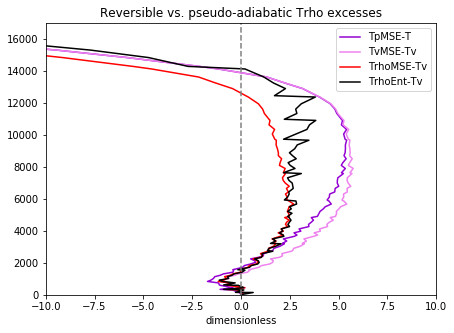

In [23]:
# Z coord plot as it becomes CAPE = integral (b dZ)
fig = plt.figure(figsize=(7,5))

plot(TpMSE-T,Z,'darkviolet')
plot( Tv(TpMSE,qvpMSE)-Tv(T,q) ,Z, 'violet')
plot( Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q) ,Z, 'r')

ylim([0,17000]); xlim([-10,10]); title('MSE and qtot conserving Tvp-Tvenv and Trhop-Tvenv')
plot( dTrho_entropy ,Z, 'k'); plot(p*0,Z,'--',color='grey')
plt.legend(['TpMSE-T','TvMSE-Tv','TrhoMSE-Tv','TrhoEnt-Tv'])
title('Reversible vs. pseudo-adiabatic Trho excesses')

dTrho_MSE = Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q)

<a name="include_ice"></a>
## <font color='green'>2. Considering the effect of latent heat of freezing
The pseudo-adiabatic process shows departure from observed tropical conditions, such as complete fallout of condensate (100% precipitaiton efficiency). The reversible process indicates that condensate is carried all the way to the upper level without precipitation or transfromation into the ice phase. Williams and Renno (1992) argued that a reversible process with ice is more accurate comparing to the previous two and shows consistent to observed characteristics of deep convection, such as enough CAPE, upper cirrus, and lightning activities. 

In [24]:
# esati, mixrat
def mixrat_i(T,p):
    es = esati(T)
    return 0.622*es/(p-es)

def delT4ice(TpMSE,p,qcpMSE,qvpMSE,Tf=0,simple=True):
# computes delta T, an increase in temperature due to latent heat of freezing and the deposition 
# of water vapor on ice (Iribarne and Godson, 1981 eq.94)
    Tref = 273.15 # reference Temp.
    Ls = 2.83e6 # J/kg, latent heat of sublimation
    Lf = 3.34e5 # J/kg, latent heat of freezing
    Cpd = 1005  # J/kg
    Cpv = 1996  # J/kg
    Cpi = 2108  # J/kg
    Rv = 461.51 # J/K/kg
    
    if simple == True:
        
        delT = Lf*qcpMSE/Cpd
        Tdev = TpMSE + delT
        
        Tdev = np.where(TpMSE < Tf, Tdev, TpMSE)
        qcpdev = np.where(TpMSE < Tf, 0, qcpMSE) # 100% convert to ice phase below zero deg
        qipdev = np.where(TpMSE < Tf, qcpMSE, 0) # 100% convert to ice phase below zero deg
        return Tdev,qcpdev,qipdev
        
    else: # precise calculation based on Iribarne and Godson (1981)
        LOOPMAX = 200 # iteration number
    
        fg0 = -8*np.ones(len(Tp))   # first guess
        k = np.zeros(len(Tp))
    
        for i in range(0, LOOPMAX+1):
                
            rs = qcp + mixrat(Tp,p) - mixrat_i(fg0,p)
            Cpt = Cpd + mixrat(Tp,p)*Cpv + rs*Cpi       
            a = ( Lf*qcp + Ls*qvp*(1-esati(Tp)/esat(Tp)) )
            b = (Cpt + mixrat_i(fg0,p)*Ls**2/(Rv*(Tp+Tref)**2))
            delT = a / b
        
            print(len(delT))
            if np.max(np.abs(delT-k)) < 1e-2:
                break
                fg0 = Tf + delT
        
            else:
                k = delT
                fg0 = Tf + delT
            
            Tdev = np.where(Tp < Tf, fg0, Tp)
        
            return Tdev

In [25]:
Tpice,qcpice,qipice = delT4ice(TpMSE,p,qcpMSE,qvpMSE,Tf=0,simple=True) # including latent heat of freezing in a simple way

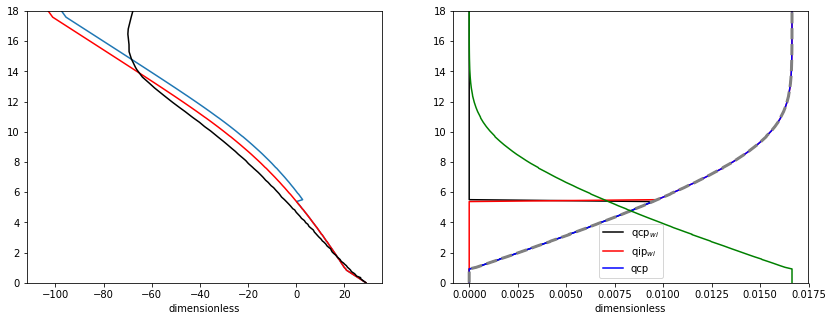

In [26]:
fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(Tpice,Z/1000)
ax1.plot(TpMSE,Z/1000,'r')
ax1.plot(T,Z/1000,'k')
ylim([0,18])

ax2 = plt.subplot(1,2,2)
ax2.plot(qcpice,Z/1000,'k')
ax2.plot(qipice,Z/1000,'r')
ax2.plot(qcpMSE,Z/1000,'b')
ax2.plot(qcpice+qipice,Z/1000,'--',color='grey',linewidth=3)
ax2.plot(qvpMSE,Z/1000,'g')
ylim([0,18])
ax2.legend(['qcp$_{wi}$','qip$_{wi}$','qcp'])

(1020, 50)

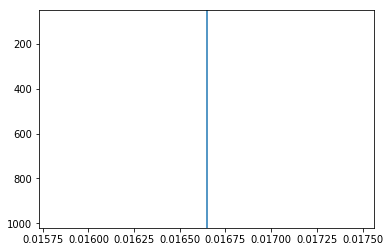

In [27]:
# conservation of total water
plot(qvpMSE+qcpice+qipice,p)
ylim([1020,50])

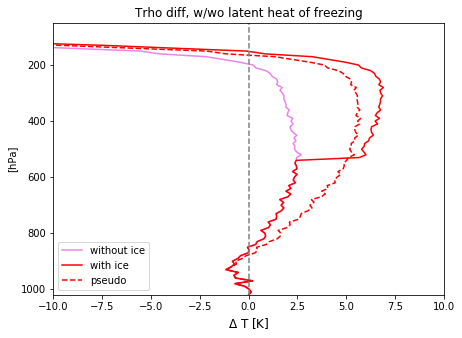

In [28]:
# Trho-Tv based on different assumptions and w/wo ice
fig = plt.figure(figsize=(7,5))

plot( Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q) ,p, 'violet') # 
plot( Trho(Tpice,qvp,qipice+qcpice)-Tv(T,q) ,p ,'r') # condensate becomes ice with the same mixing ratio
plot( Trho(Tp_precip,qvp_precip, 0)-Tv(T,q) ,p, '--r')
ylim([1020,50]); xlim([-10,10]); title('Trho diff, w/wo latent heat of freezing')
plot(p*0,p,'--',color='grey') # entropy
plt.legend(['without ice','with ice','pseudo'])
plt.xlabel('$\Delta$ T [K]',fontsize=12)
plt.ylabel('[hPa]')

dTrho_MSE = Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q)

---------------
<a name="CAPE"></a>
### Determination of convective available potential energy (CAPE) and convective inhibition energy (CINE)
The buoyancy acceleration is in the form of 
\begin{equation*}
b = \frac{T_{vp}-T_v}{T_v}g
\end{equation*}
where g is gravity acceleration, 9.8m/s$^2$. T$_{vp}$ and T$_v$ are virtual temperature of 
the parcel and its environment, respectively.

The definition of CAPE is the vertical integrated buoyancy between LFC and LNB
\begin{equation*}
CAPE = \int_{LFC}^{LNB}b \ \ dz
\end{equation*}
where LFC is the level of free convection (b>0), and LNB is the level of neutral buoyancy (b=0)

and the definition of CAPE is the vertical integrated buoyancy between the surface and LFC
\begin{equation*}
CIN = \int_{sfc}^{LFC}b \ \ dz
\end{equation*}

Besides, a basic meteorological concept is that updraft vertical velocities are closely related to CAPE, the maximum vertical velocity of a rising parcel can be estimated as
\begin{equation*}
W_{max} = \sqrt{2CAPE}
\end{equation*}

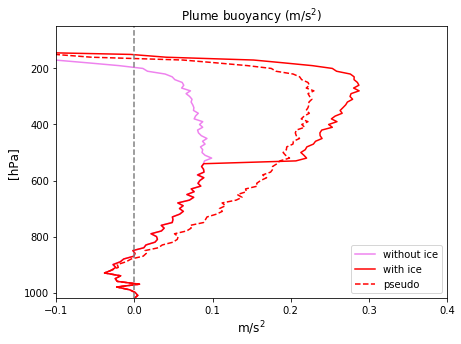

In [30]:
dTrho = Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q) # no mixing, no ice
dTrho_ice = Trho(Tpice,qvp,qcpice+qipice)-Tv(T,q)
dTrho_pseu = Trho(Tp_precip,qvp_precip, 0)-Tv(T,q)

b = 9.8*dTrho/(Tv(T,q) + 273.15)
b_ice = 9.8*dTrho_ice/(Tv(T,q) + 273.15)
b_pseu = 9.8*dTrho_pseu/(Tv(T,q) + 273.15)

fig = plt.figure(figsize=(7,5))

plot(b , p,'violet'); plot(b_ice, p,'r');plot(b_pseu, p,'--r')
plot(p*0, p,'--',color='grey')
ylim([1020,50]); xlim([-0.1,0.4]); 
title('Plume buoyancy (m/s$^2$)');xlabel('m/s$^2$',fontsize=12);ylabel('[hPa]',fontsize=12)
plt.legend(['without ice','with ice','pseudo'])

In [31]:
fig.savefig('/Users/willytsai/Desktop/buoyancy_withice.png',dpi=300)

CAPE without ice:  732.0 J/kg
CAPE with ice:     2343.0 J/kg
CAPE pesudo:       2101.0 J/kg


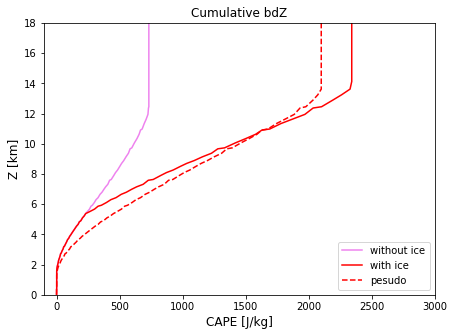

In [32]:
dZ = np.gradient(Z)

fig = plt.figure(figsize=(7,5))

cape = np.cumsum( np.where((b>0),b,0) *dZ)
cape_ice = np.cumsum( np.where((b_ice>0),b_ice,0) *dZ)
cape_pseu = np.cumsum( np.where((b_pseu>0),b_pseu,0) *dZ )
plot(cape,Z/1000,'violet')
plot(cape_ice,Z/1000,'r')
plot(cape_pseu,Z/1000,'--r')
plt.legend(['without ice','with ice','pesudo'],loc=4)
title('Cumulative bdZ'); xlabel('CAPE [J/kg]',fontsize=12); ylabel('Z [km]',fontsize=12)
ylim([0,18]); xlim([-100,3000]); 

print('CAPE without ice:  ' + str(round(cape[-1])) + ' J/kg')
print('CAPE with ice:     ' + str(round(cape_ice[-1])) + ' J/kg')
print('CAPE pesudo:       '  + str(round(cape_pseu[-1])) + ' J/kg')

If we consider the latent heat of freezing in the reversible process, increasing buoyancy of the parcel due to the heating leads to much higher CAPE. On the other hand, the pseudo-adiabatic process removes condensate immediately, so there is no liquid water which can tranform into the ice phase above the freezing level (~5 km).<br>
### <font color='k'>The impact of latent heat of freezing on the CAPE is considerably huge.

<a name="entraining"></a>
## <font color='green'>3. Entrainment methods and applications
---------------
#### <font color='grey'>Detrainment is assumed zero in this discussion.
For the p-coordinate, The standard continuity expression for mass flux in the updraft is 
\begin{equation*}
\frac {d{M}}{d{p}} = M(\epsilon - \delta), \   \ 
\end{equation*}

Considering entrainment rate is much larger than detrainment rate, 
\begin{equation*}
M = M_0 exp(\epsilon (p_0-p))
\end{equation*}


In this form, the mass flux increases exponentially with height due to entraining air from the environment.<br>

Becasue of the entrainment, the conserved variables (MSE or entropy) is not conserved but mixed with environmental values. <br>
\begin{equation*}
\frac {d{r}}{d{p}} = X(\hat{r} - r)
\end{equation*}
where $r$ is the conserved variable, r_hat is its environmental value. X is the entrainment rate with a unit of hPa$^{-1}$

After reconstructing the entrainment formula, the conserved variable in the parcel at each level with entrained environmental air becomes

\begin{equation*}
r_k = (1 - X_{k-1}\Delta p)r_{k-1} + X_{k-1}\Delta p\hat{r}_{k-1}
\end{equation*}

### Three entrainment assumptions are applied as follows:

### (1) constant mixing rate <font color='grey' size=2>(Stommel 1947; Siebesma et al. 2007)
The mixing coefficient, X$\Delta$p, is specified as a constant value at all levels
\begin{equation*}
    X = 0.001 \  \ hPa^{-1}
\end{equation*}
which means the originally undiluted parcel will mix with the environmental air with a fraction of 0.001 per hPa. 

### (2) mixing rate with vertical dependence <font color='grey' size=2>(Holloway and Neelin, 2009; Schiro and Neelin 2019) 

#### 1. Deep inflow mixing A: corresponding to LES-based simulation
\begin{equation*}
X_k\Delta p = c_\epsilon z_k^{-1}\Delta z , \     \ 
c_\epsilon = 0.4
\end{equation*}

#### 2. Deep inflow mixing B: an linear increase in mass flux at low levels, tapering at midtroposphere
Observations of vertical velocity show that the mass flux increases nearly linearly through a deep lower-tropospheric layer, motivating the assumptions for the mass flux profile in deep-inflow-B here. The entrainment depends on mass flux (updraft) itself
\begin{equation*}
X_k\Delta p = -m^{-1}(\partial m/\partial p)\Delta p
\end{equation*}
\begin{equation*}
Below \  \ 900hPa,\   \, \ \ X_k\Delta p = (p_0 - p_k)^{-1}\Delta p
\end{equation*}
\begin{equation*}
Above \  \ 430hPa,\   \ X_k = 0
\end{equation*}

### (3) interactive entrainment <font color='grey' size=2>(Sahany et al., 2012)
This assumption takes into account effects of
vertical acceleration of the plume that would enhance entrainment by a mass flux balance.Therefore,unlike previous formulations which are independent of the evolution of the parcel, the interactive entrainment is dynamically determined by the updraft vertical velocity. 

\begin{equation*}
X_k = X_{min} + \frac{\omega_k - \omega_{k-1}}{\Delta p(\omega_k + \omega_{k-1})/2}
\end{equation*}
<br>
where $\omega$ is the pressure vertical velocity and $X_{min}$ is the minimum prescribed mixing rate, 0.001 hPa$^{-1}$.

The equation of vertical veolcity can be expressed as 
\begin{equation*}
\frac{\partial W^2_u}{\partial z} = -\frac{1}{z}W^2_u + B
\end{equation*}

A solution of updraft vertical velocity is 
\begin{equation*}
W^2_u = z^{-1}\int_{0}^{z}z' B dz' + W^2_0(\frac{z}{z_0})^{-1}, \  \ W_0 = 10 m/s, \  \ z_0 = 350 m
\end{equation*}


In [33]:
def entrain_const(X,p):
    dp = -np.append(0,np.diff(p))
    return X*dp

def entrain_coeffA(Z,p,ce=0.4):
# calculate entrainment coefficient from depp inflow mixing A
    dz = np.append(0,np.diff(Z))
    dp = -np.append(0,np.diff(p))
    X = ce*dz/Z/dp
    X[0] = 0 
    return X*dp

def entrain_coeffB(p):
# calculate entrainment coefficient from deep inflow mixing B

    # specify a vertical profile of m that increases linearly at lower levels:
    # m=0 at surface and m reaches to the maximum at 430hPa, no entrainment above
    ps = p[0]
    b = pi/2/(1-430/ps); a = -b/ps
    m = sin( a*p + b ) # specified vertical profile of mass flux 
    
    #dmdp = np.gradient(m,p)
    dmdp = np.append(0,np.diff(m))/np.append(0,np.diff(p))
    dp = -np.append(0,np.diff(p))
    X = -dmdp/m
        
    X = np.where(p > 950, 1/(ps-p),X)
    X = np.where(p > 430, X, 0) # no entrainment above 430 hPa
    X[0] = 0 # at surface, denominator is zero
    
    return X*dp, m

def conserved_dmix(s,q,X):
# calculate entrained conserved variable over the whole levels
# where sp is conserved variable of parcel, s is environmental value,
# and X is entrainment coefficient.
        
    s_mix = np.zeros(len(s)); q_mix = s_mix.copy()
    s_mix[0] = s[0]; q_mix[0] = q[0] # total water content
    for z in range(1,len(s)):
        s_mix[z] = (1-X[z-1])*s_mix[z-1] + X[z-1]*s[z-1]
        q_mix[z] = (1-X[z-1])*q_mix[z-1] + X[z-1]*q[z-1]
        
    return s_mix, q_mix

In [34]:
def entrain_dyn(TpMSE,qvpMSE,qcpMSE,T,q,Z,p,Xmin=1e-3):
# entrainment coeff for interactive/dynamic entrainment rate
# considering the dependence of buoyancy/vertical velocity
    Rd = 287.15
    Z0 = 350 # meter
    W0 = 10 # m/s
    ps = p[0]
    b = 9.8*(Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q))/(Tv(T,q)+273.15) # buoyancy 
    
    # diagnosis of vertical velocity
    W2 = np.zeros(len(Z))
    dz = np.append(0,np.diff(Z))
    for k in range(len(Z)):
        B = np.trapz(b[:k+1]*Z[:k+1],Z[:k+1])
        W2[k] = B/Z[k] + W0**2*((Z[k]/Z0)**-1)
    
    W = W2**(1/2) # vertical velocity [m/s]
        
    # convert W into omega: omega = -ro*g*w
    ro = p/Rd*(Tv(TpMSE,qvpMSE)+273.15)*100
    omega = -ro*9.8*W
    
    X = W2.copy()
    dp = -np.append(0,np.diff(p))
    for k in range(1,len(p)):
        X[k] = Xmin + (omega[k]-omega[k-1])/(dp[k]*(omega[k]+omega[k-1])/2)
    
    X = np.where(p > 950, 1/(ps-p),X)
    X[0] = 0

    return X*dp, omega, B

In [35]:
# calculate mixing coefficients for each method
X_c1 = entrain_const(1e-3,p)
hp_c1, qp_c1 = conserved_dmix(h,q,X_c1)

X_A = entrain_coeffA(Z,p,0.4)
hp_mixA, qp_mixA = conserved_dmix(h,q,X_A)

X_B, m = entrain_coeffB(p)
hp_mixB, qp_mixB = conserved_dmix(h,q,X_B)

X_dyn, omega_diag, B_diag = entrain_dyn(TpMSE,qvpMSE,qcpMSE,T,q,Z,p,Xmin=1e-3)
hp_mixdyn, qp_mixdyn = conserved_dmix(h,q,X_dyn)

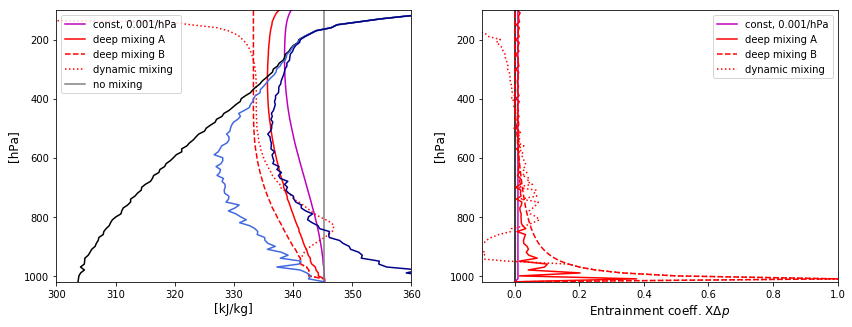

In [38]:
fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(1,2,1)

# mixing curves
ax1.plot(hp_c1/1000,p,'m',zorder=2) # const epsilon 1/15km
ax1.plot(hp_mixA/1000,p,'r',zorder=2) # deep flow entrainment A
ax1.plot(hp_mixB/1000,p,'--r',zorder=2) # deep flow entrainment B
ax1.plot(hp_mixdyn/1000,p,':r',zorder=2) # dynamic entrainment
ax1.plot(h*0+h[0]/1000,p,'grey',zorder=2)
xlabel('[kJ/kg]',fontsize=12);ylabel('[hPa]',fontsize=12)
xlim([300,360]); ylim([1020,100])
ax1.legend(['const, 0.001/hPa','deep mixing A','deep mixing B','dynamic mixing','no mixing'])

ax1.plot(s/1000, p, 'k')
ax1.plot(h/1000,p,'royalblue')
ax1.plot(hs/1000, p, 'darkblue')

dz = np.gradient(Z)
ax2 = plt.subplot(1,2,2)
ax2.plot(X_c1,p,'m',zorder=2)
ax2.plot(X_A,p,'r',zorder=2)
ax2.plot(X_B,p,'--r',zorder=2)
ax2.plot(X_dyn,p,':r',zorder=2)
ax2.plot(X_c1*0,p,color='k',zorder=1)
xlabel('Entrainment coeff. X$\Delta p$',fontsize=12);ylabel('[hPa]',fontsize=12)
ylim([1020,100]);xlim([-0.1,1]) 
ax2.legend(['const, 0.001/hPa','deep mixing A','deep mixing B','dynamic mixing'])

Dynamic mixing may have negative values in this case, which may be associated with the acceleration of vertical velocity and the specified Xmin. More investigations needed.

In [40]:
# calculate Tp for each entrainment method
Tp_c1,qvp_c1 = invert_MSE(hp_c1,qp_c1, np.where(Z<20000.,Z,20000.), np.where(p>50.,p,50.))
qcp_c1 = qp_c1 - qvp_c1
Tpice_c1,qcpice_c1,qipice_c1  = delT4ice(Tp_c1, p, qcp_c1, qvp_c1, Tf=0, simple=True)

Tp_mixA,qvp_mixA = invert_MSE(hp_mixA,qp_mixA, np.where(Z<20000.,Z,20000.), np.where(p>50.,p,50.))
qcp_mixA = qp_mixA - qvp_mixA
Tpice_mixA,qcpice_mixA,qipice_mixA  = delT4ice(Tp_mixA, p, qcp_mixA, qvp_mixA, Tf=0, simple=True)

Tp_mixB,qvp_mixB = invert_MSE(hp_mixB,qp_mixB, np.where(Z<20000.,Z,20000.), np.where(p>50.,p,50.))
qcp_mixB = qp_mixB - qvp_mixB
Tpice_mixB,qcpice_mixB,qipice_mixB  = delT4ice(Tp_mixB, p, qcp_mixB, qvp_mixB, Tf=0, simple=True)

Tp_mixdyn,qvp_mixdyn = invert_MSE(hp_mixdyn,qp_mixdyn, np.where(Z<20000.,Z,20000.), np.where(p>50.,p,50.))
qcp_mixdyn = qp_mixdyn - qvp_mixdyn
Tpice_dyn,qcpice_dyn,qipice_dyn  = delT4ice(Tp_mixdyn, p, qcp_mixdyn, qvp_mixdyn, Tf=0, simple=True)

MSE invert not converging
MSE invert not converging
MSE invert not converging
MSE invert not converging


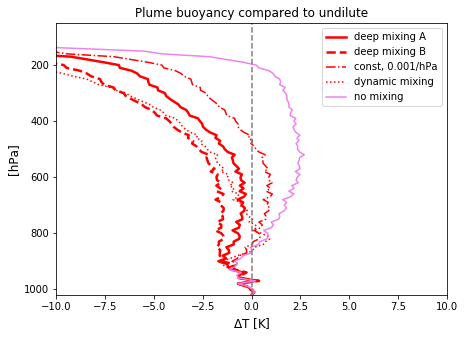

In [41]:
fig = plt.figure(figsize=(7,5))

plot( Trho(Tp_mixA,qvp_mixA,qcp_mixA)-Tv(T,q) ,p, 'r',linewidth=2.5)
plot( Trho(Tp_mixB,qvp_mixB,qcp_mixB)-Tv(T,q) ,p, '--r',linewidth=2.5)
plot( Trho(Tp_c1,qvp_c1,qcp_c1)-Tv(T,q) ,p, '-.r')
plot( Trho(Tp_mixdyn,qvp_mixdyn,qcp_mixdyn)-Tv(T,q) ,p, ':r')
plot( dTrho_MSE ,p ,'violet') # condensate loading
plot(p*0,p,'--',color='grey')

ylim([1020,50]); xlim([-10,10]); 
title('Plume buoyancy compared to undilute');xlabel('$\Delta$T [K]',fontsize=12);ylabel('[hPa]',fontsize=12)
plt.legend(['deep mixing A','deep mixing B','const, 0.001/hPa','dynamic mixing','no mixing'])

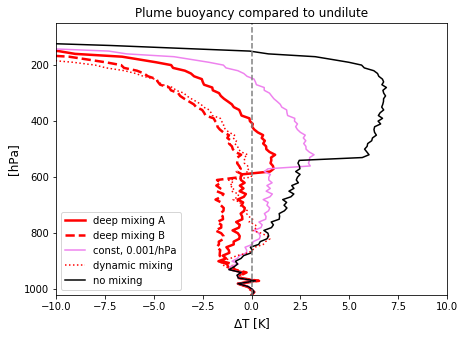

In [42]:
fig = plt.figure(figsize=(7,5))

plot( Trho(Tpice_mixA,qvp_mixA,qcpice_mixA+qipice_mixA)-Tv(T,q) ,p, 'r',linewidth=2.5)
plot( Trho(Tpice_mixB,qvp_mixB,qcpice_mixB+qipice_mixB)-Tv(T,q) ,p, '--r',linewidth=2.5)
plot( Trho(Tpice_c1,qvp_c1,qcpice_c1+qipice_c1)-Tv(T,q) ,p, 'violet')
plot( Trho(Tpice_dyn,qvp_mixdyn,qcpice_dyn+qipice_dyn)-Tv(T,q) ,p, ':r')
plot( Trho(Tpice,qvp,qcpice+qipice)-Tv(T,q) ,p ,'k') # no mixing
plot(p*0,p,'--',color='grey')

ylim([1020,50]); xlim([-10,10]); 
title('Plume buoyancy compared to undilute'); xlabel('$\Delta$T [K]',fontsize=12);ylabel('[hPa]',fontsize=12)
plt.legend(['deep mixing A','deep mixing B','const, 0.001/hPa','dynamic mixing','no mixing'])

### Sensitivities of CAPE and LNB to constant mixing rates

In [44]:
mixing_rates = np.array([5e-4,1e-3,2e-3,3e-3,4e-3]) # entrainment rate [%/hpa]
cape_sum = np.zeros(len(mixing_rates))
LNB_sum = cape_sum.copy()
dTpice_sum = np.zeros((len(mixing_rates),len(p)))
Xdp_sum = dTpice_sum.copy()

for n,X in enumerate(mixing_rates):
    
    Xdp_cmix = entrain_const(X,p)
    hp_cmix, qp_cmix = conserved_dmix(h,q,Xdp_cmix) # vars after mixing  
    Tp_cmix, qvp_cmix = invert_MSE(hp_cmix,qp_cmix, np.where(Z<20000.,Z,20000.), np.where(p>50.,p,50.))
    qcp_cmix = qp_cmix - qvp_cmix
    Tpice_cmix,qcpice_cmix,qipice_cmix  = delT4ice(Tp_cmix, p, qcp_cmix, qvp_cmix, Tf=0, simple=True)
    
    Xdp_sum[n] = Xdp_cmix
    dTpice_sum[n,:] = Trho(Tpice_cmix,qvp_cmix,qcpice_cmix+qipice_cmix)-Tv(T,q)
    
    b_mix = 9.8*(dTpice_sum[n,:])/(Tv(T,q)+273.15) # buoyancy
    b_mix = np.where(p>50,b_mix,0) # avoid noises at extremely high altitudes
    cape_sum[n] = np.cumsum( np.where((b_mix>0),b_mix,0) *dZ)[-1]
    LNB_idx = np.where(b_mix>0)[0][-1] # last point where b > 0
    LNB_sum[n] = p[LNB_idx]

MSE invert not converging
MSE invert not converging
MSE invert not converging
MSE invert not converging
MSE invert not converging


Text(0, 0.5, '[hPa]')

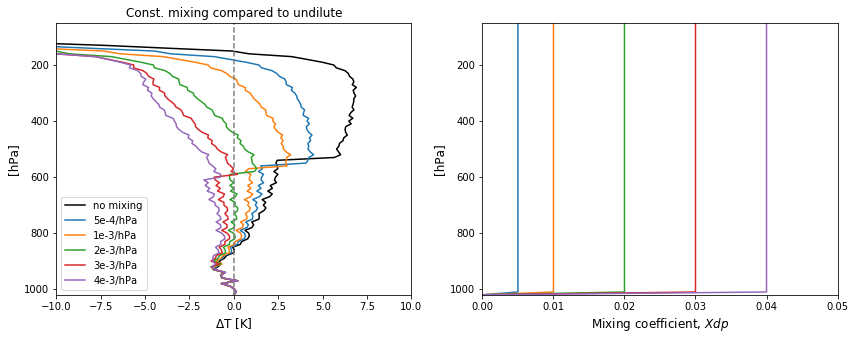

In [45]:
fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(Trho(Tpice,qvp,qcpice+qipice)-Tv(T,q),p ,'k') # no mixing
for n in range(len(mixing_rates)):
    ax1.plot(dTpice_sum[n],p)
    ax1.set_ylim([1020,50]); ax1.set_xlim([-10,10]); 
ax1.plot(p*0,p,'--',color='grey')
ax1.set_title('Const. mixing compared to undilute')
ax1.set_xlabel('$\Delta$T [K]',fontsize=12);ax1.set_ylabel('[hPa]',fontsize=12)
ax1.legend(['no mixing','5e-4/hPa','1e-3/hPa','2e-3/hPa','3e-3/hPa','4e-3/hPa'])

ax2 = plt.subplot(1,2,2)
for n in range(len(mixing_rates)):
    ax2.plot(Xdp_sum[n,:],p)
    ax2.set_ylim([1020,50]); ax2.set_xlim([0,0.05]); 
ax2.set_xlabel('Mixing coefficient, $Xdp$',fontsize=12);ax2.set_ylabel('[hPa]',fontsize=12)


Text(0, 0.5, 'LNB [hPa]')

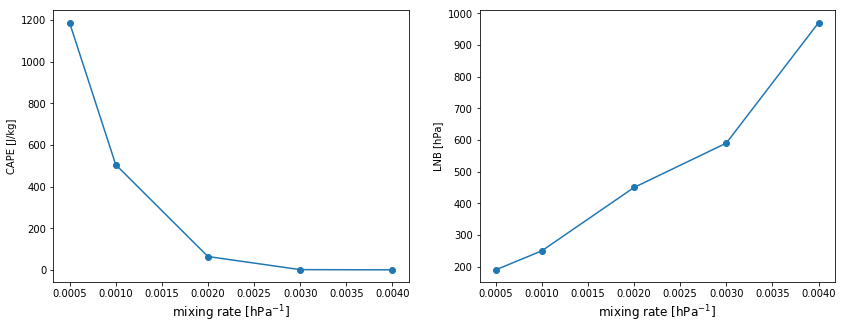

In [47]:
fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(mixing_rates,cape_sum,'-o')
ax1.set_xlabel('mixing rate [hPa$^{-1}$]',fontsize=12)
ax1.set_ylabel('CAPE [J/kg]')

ax2 = plt.subplot(1,2,2)
ax2.plot(mixing_rates,LNB_sum,'-o')
ax2.set_xlabel('mixing rate [hPa$^{-1}$]',fontsize=12)
ax2.set_ylabel('LNB [hPa]')

### Conclusions
- Both reversible and pseudo-adiabatic processed are discussed using a parcel model. Parcel buoyancy is strongly damped by condensate loading.
- Considering the existence of ice phase and associated latent heat allows the parcel rising to upper levels, becoming a deeper plume.
- Four types of entrainment rate assumptions are tested: (1) constant mixing, (2) inversely proportional to z, (3) mass-flux determined, and (4) interactive mixing depending on velocity. The plume buoyancy is quite sensitive to different entrainment assumptions.
- Unlike the free troposphere, buoyancy within boundary layer (~ below 950 hPa) is less subject to different entrainment treatments.
- How entrainment is represented in GCMs determines characteristics of moist convection, including the LNB, CAPE and associated precipitation processes. 

<a href="#top">Top</a>
<hr style="height:2px;">